In [ ]:
import timm, torch
import torch.nn as nn

In [ ]:
RES = timm.create_model("resnet50", pretrained=True)
VGG = timm.create_model("vgg16_bn", pretrained=True)
INC = timm.create_model("inception_v3", pretrained=True)

In [ ]:
RES.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
VGG.head.fc = nn.Linear(in_features=4096, out_features=2, bias=True)
INC.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

In [1]:
from torchvision.models import resnet18
model = resnet18(pretrained=True).eval()

from torchcam.methods import SmoothGradCAMpp
cam_extractor = SmoothGradCAMpp(model)

c:\Users\PC00\anaconda3\envs\CAM\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC00\anaconda3\envs\CAM\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model = resnet18(pretrained=True).eval()
target_layer = model.layer4[2].conv3
# Get your input
img = read_image("D:/Datasets/SJS/Processed/SJS/PTG_46512-0000.jpg")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model, target_layer) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

c:\Users\PC00\anaconda3\envs\CAM\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC00\anaconda3\envs\CAM\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


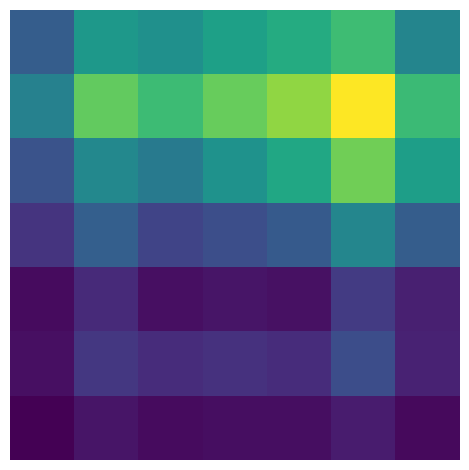

In [4]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

def save_cam(image):
    result = overlay_mask(to_pil_image(image), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
    return

In [ ]:
import utils, data, models, PIL
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

control = "NONSJS"

model = models.ResNet(pretrained=True)
model.eval()

target_layer = model.layer4[2].conv3

max_images = data.read_max_img_paths(f"C:/Users/PC00/Desktop/SJS/{control}_max_output_images.txt")
for image in max_images:
    diagnosis = image.split("/")[4]
    gland = image.split("/")[-1].split("_")[0]
    ID = image.split("/")[-1].split("_")[1].split("-")[0]
    
    save_folder = f"E:/Results/SJS/Figures/CAM/Trained/{control}_SJS/{diagnosis}/"
    
    image_name = f"{save_folder}{ID}_{gland}.jpg"

    """(1) Transform the image and put it into the model."""
    transformed = utils.preprocessing(PIL.Image.open(image)).float().unsqueeze(0)
    
    with SmoothGradCAMpp(model, target_layer) as cam_extractor:
        out = model(transformed)
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    
    result = overlay_mask(PIL.Image.open(image), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    plt.figure(); plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.savefig(image_name); plt.close()

c:\Users\PC00\anaconda3\envs\CAM\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC00\anaconda3\envs\CAM\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
import os, shutil
import pandas as pd

control_group = "NONSJS"
excel_path = f"E:\\LIMITLESS_DL\\SJS\\Correct_IDs({control_group}).xlsx"
df = pd.read_excel(excel_path)
total_paths = df["Path"]
total_classes = df["Class"]

data_root = "D:\\Datasets\\SJS\\Processed\\"

dst_root = "C:\\Users\\PC00\\Desktop\\GradCAM\\"
control_root = os.path.join(dst_root, f"{control_group}_SJS")
os.makedirs(os.path.join(control_root, "PTG"), exist_ok=True)
os.makedirs(os.path.join(control_root, "SMG"), exist_ok=True)

for path in total_paths:
    filename = os.path.basename(path)
    curr_ID = filename.split("_")[1].split("-")[0]
    curr_gland = filename.split("_")[0]
    curr_class = path.split("\\")[4]
    for img in os.listdir(os.path.join(data_root, curr_class)):
        if curr_ID in img:
            src_path = os.path.join(data_root, curr_class, img)
            break
    dst_path = os.path.join(control_root, curr_gland, f"{curr_ID}_{curr_gland}.jpg")
    shutil.copy(src_path, dst_path)

In [23]:
import os, data
import pandas as pd

data_root = "D:\\Datasets\\SJS\\Processed\\"
control_group = "NONSJS"
SJS_path = data.path_by_diagnosis(data_root, "SJS")
CTR_path = data.path_by_diagnosis(data_root, control_group)
SJS_ID = data.ID_summary(SJS_path)
CTR_ID = data.ID_summary(CTR_path)

result_root = "C:\\Users\\PC00\\Desktop\\GradCAM\\"
control_root = os.path.join(result_root, f"{control_group}_SJS")

PG_df, SG_df = dict(), dict()
PG_IDs, PG_classes = [], []
SG_IDs, SG_classes = [], []
for gland in os.listdir(control_root):
    gland_dir = os.path.join(control_root, gland)
    for filename in os.listdir(gland_dir):
        curr_ID = filename.split("_")[0]
        if curr_ID in SJS_ID: curr_class = "SJS"
        else: curr_class = control_group
        if gland == "PTG":
            PG_IDs.append(curr_ID)
            PG_classes.append(curr_class)
        else:
            SG_IDs.append(curr_ID)
            SG_classes.append(curr_class)
PG_df["ID"] = PG_IDs
PG_df["Class"] = PG_classes
SG_df["ID"] = SG_IDs
SG_df["Class"] = SG_classes
pd.DataFrame(PG_df).to_excel(os.path.join(control_root, "PTG.xlsx"))
pd.DataFrame(SG_df).to_excel(os.path.join(control_root, "SMG.xlsx"))